# PoliDuckies
A notebook with the complete pipeline

### Standard imports

In [18]:
import os 
branch = "daffy" #@param ['master', 'daffy']

if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if "/gym-duckietown" not in os.getcwd():
  os.chdir('gym-duckietown')
  
!apt install xvfb -y
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.14
!pip install duckietown-gym-daffy
!pip install poliduckie-segmentation

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.3-2ubuntu2.9).
0 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.


In [1]:
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown

# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.4.3 path /usr/local/lib/python3.9/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.9/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.1.1 path /usr/local/lib/python3.9/dist-packages
DEBUG:nodes:version 6.2.17 path /usr/local/lib/python3.9/dist-packages pyparsing 2.4.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.34 path /usr/local/lib/python3.9/dist-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True}


In [2]:
map_name = "Duckietown-small_loop-v0"

### Methods

In [3]:
from poliduckie_segmentation.segmentation import Segmentation

seg = Segmentation()

def segmentation(image):
  """
    Returns the image from the simulation with the segmentation

    Image: np.Array
    ------
    Image: np.Array
  """
  resized = cv2.resize(image, (320, 240))
  return seg.predict(resized)

2023-04-04 16:02:27.631606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 16:02:27.718561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 16:02:28.096167: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 16:02:28.097474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:02:29.478095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [4]:
from poliduckie_segmentation import BirdEyeView

matrixPath = './BirdEyeMatrices/SegmentationOutput.pkl'
birdeye = BirdEyeView(path = matrixPath)

def birdEyeTransform(image):
  """
    Returns the image from the simulation with the bird eye view

    Image: np.Array
    ------
    Image: np.Array
  """
  return birdeye.computeBirdEye(image)

In [5]:
from poliduckie_segmentation.line_extraction import LineExtraction

lineExtraction_ = LineExtraction()

def lineExtraction(image, n_points=100, mode="bezier", bezier_degree=3):
  """
    Returns the central line extracted as a numpy array. The mode can be either "bezier" or "spline"

    Image: np.Array
    n_points: int
    mode: str
    bezier_degree: int
    ------
    Line: np.Array
  """
  if mode == "bezier":
    bezier_points = lineExtraction_.bezier_fit(image, degree=bezier_degree, nPoints=n_points)
    return bezier_points
  
  elif mode == "spline":
    spline_points = lineExtraction_.spline_interpolation(image, nPoints=n_points)
    return spline_points

In [16]:
METER_PER_PIXEL = 0.4 / 150
CAR_POSITION = [320/2, 240]

def computeReference(line, N):
  """
    Returns the references in meters
    Reference is a list with dimension (2, N)
    N is the prediction horizon of the MPC

    Line: np.Array
    N: int
    ------
    reference: List[[List[Float], List[Float]]]
  """
  reference = line[:N]

  #center around car position
  reference[0] = [x - CAR_POSITION[0] for x in reference[0]]
  reference[1] = [y - CAR_POSITION[1] for y in reference[1]]

  #convert to meters
  reference[0] = [x * METER_PER_PIXEL for x in reference[0]]
  reference[1] = [y * METER_PER_PIXEL for y in reference[1]]
  
  return reference

In [7]:
from poliduckie_segmentation.control import MPC
M = MPC()

def runMpc(state, reference):
  """
    Returns the control inputs to give to the car.
    State is [x, y, theta, v, w]
    Reference is a list with dimension (2, N)

    state: [Float, Float, Float, Float, Float]
    reference: List[[List[Float], List[Float]]]
    ------
    u: List[Float, Float]
  """
  return M.mpc(state, reference)

In [9]:
imageVisualization = 'Plt' #@param ['Plt', 'CV2']

def plt_imshow(image):
  plt.imshow(image)
  plt.show()


if imageVisualization == 'CV2':
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = plt_imshow

### Simulation

INFO:duckietown_world: data: /usr/local/lib/python3.9/dist-packages/duckietown_world/data
/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, w

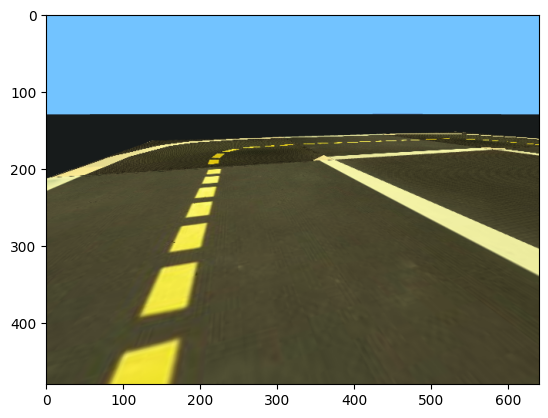

In [10]:
# display = Display(visible=0, size=(1400, 900))
# display.start()
env = gym.make(map_name)
imshow(env.reset())

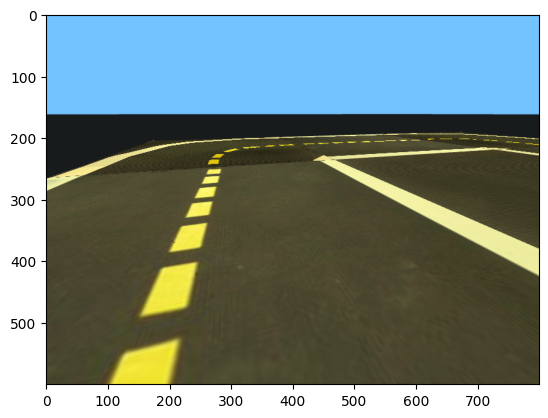

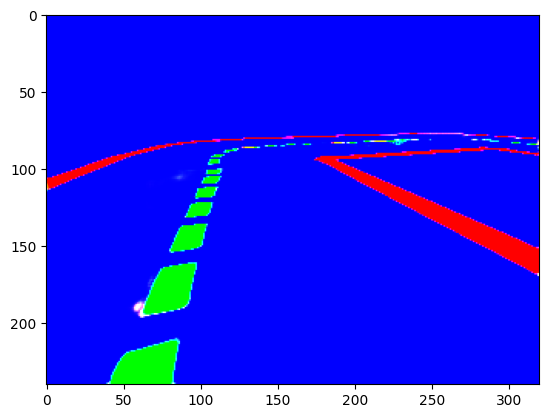

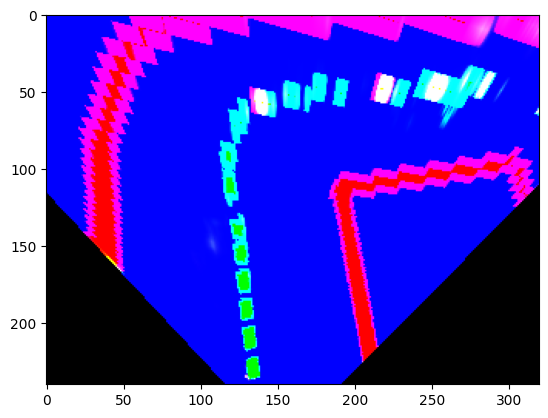

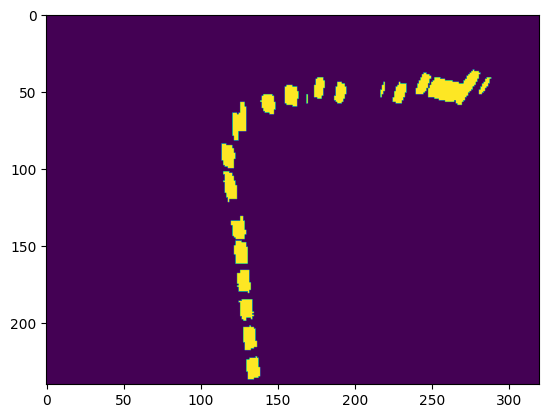

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


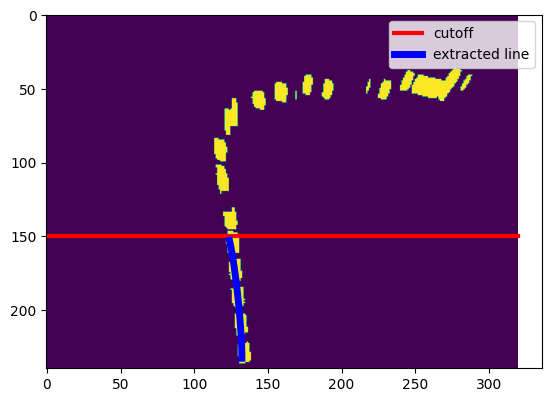

[[-0.07380392 -0.07378878 -0.07378065 -0.07377947 -0.07378519 -0.07379773
  -0.07381703 -0.07384302 -0.07387565 -0.07391485 -0.07396055 -0.07401269
  -0.0740712  -0.07413602 -0.07420709 -0.07428434 -0.07436771 -0.07445713
  -0.07455254 -0.07465387 -0.07476107 -0.07487406 -0.07499278 -0.07511717
  -0.07524716 -0.07538268 -0.07552369 -0.0756701  -0.07582186 -0.07597889
  -0.07614115 -0.07630856 -0.07648105 -0.07665857 -0.07684105 -0.07702842
  -0.07722063 -0.0774176  -0.07761927 -0.07782558 -0.07803646 -0.07825185
  -0.07847169 -0.07869591 -0.07892444 -0.07915722 -0.0793942  -0.07963529
  -0.07988045 -0.08012959 -0.08038267 -0.08063961 -0.08090036 -0.08116484
  -0.081433   -0.08170476 -0.08198007 -0.08225885 -0.08254106 -0.08282661
  -0.08311545 -0.08340751 -0.08370273 -0.08400105 -0.08430239 -0.0846067
  -0.08491391 -0.08522395 -0.08553677 -0.0858523  -0.08617046 -0.08649121
  -0.08681448 -0.08714019 -0.08746829 -0.08779871 -0.08813139 -0.08846626
  -0.08880326 -0.08914232 -0.08948339 -

RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 1 (r) has mismatching shape. Got 2-by-100. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 2-by-3)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

In [18]:
from poliduckie_segmentation.model import Model

VERTICAL_CUTOFF = 150

# State X = [x, y, angle, longitudinal speed, angular speed]
state = [0,0,0,0,0]

F = Model()

image_recording = []

for _ in range(100):
  image = env.render(mode="rgb_array")
  image_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  imshow(image)

  image_recording.append(image)
  image_segmentation = segmentation(image_BGR)[0]*255
  imshow(image_segmentation)

  image_birdeye = birdEyeTransform(image_segmentation)
  imshow(image_birdeye)

  dottedLineMask = cv2.threshold(image_birdeye[:, :, 1], 70, 255, cv2.THRESH_BINARY)[1]
  imshow(dottedLineMask)

  dottedLineMaskCropped = dottedLineMask[VERTICAL_CUTOFF:, :]

  line = lineExtraction(dottedLineMaskCropped, mode='bezier')
  plt.imshow(dottedLineMask)
  plt.plot([0, 320], [VERTICAL_CUTOFF, VERTICAL_CUTOFF], color='red', linewidth=3, label='cutoff')
  plt.plot(line[0], line[1] + VERTICAL_CUTOFF, color='blue', linewidth=5, label='extracted line')
  plt.legend()
  plt.show()

  reference = computeReference(line, 10)
  print(reference)
  
  action = runMpc(state, reference)
  state = F.step(*state, action)
  env.step(action)